<a href="https://colab.research.google.com/github/psanabriaUC/BatteryDatasetImplementation/blob/master/Battery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manual de preparación y uso del modelo de *Deep Learning* para prediccion del SoH de la batería
En este Python Notebook se muestra y se analiza como debe ser tratado el dataset de carga/descarga de baterias obtenido de la NASA. Igualmente se muestra
como se prepara el modelo propuesto por [1] y [2] y su encoding necesario para ser utilizado

## Requisitos
Para la fase de entrenamiento de este modelo es necesario tener instalado Python 3.x junto a las siguientes librerías:

* Tensorflow 2.0
* Numpy
* Pandas
* Scipy
* Sci-kit learn
* Matplot
* Seaborn

Para la fase de predicción de este modelo es necesario tener las mismas librerías con la excepción a Matplot y Seaborn


## Preparación del dataset
Debido a que este manual se trabajó desde Google Colab (esto puede no ser necesario hacerlo en un entorno offline), es necesario descargar el dataset y después descomprimirlo en un directorio especifico.

In [1]:
%tensorflow_version 2.x
%matplotlib inline
!pip show tensorflow
!wget -cq https://ti.arc.nasa.gov/c/5 -O naza.zip
!unzip -qqo naza.zip -d battery_data

TensorFlow 2.x selected.
Name: tensorflow
Version: 2.1.0rc1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-2.1.0/python3.6
Requires: six, numpy, google-pasta, gast, tensorboard, tensorflow-estimator, termcolor, absl-py, protobuf, keras-preprocessing, grpcio, astor, wrapt, opt-einsum, keras-applications, wheel
Required-by: stable-baselines, magenta, fancyimpute


## Importación de librerías
En esta parte se important todas las librerías necesarias para el tratamiento del dataset

In [0]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Carga del dataset en memoria
Segun el README del dataset, los datos estan almacenados en varios archivos ".mat", cada archivo corresponde a una batería en concreto y la estructura de los datos de cada archivo es la siguiente (copiado desde el README del dataset):

```
Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
	   for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
	   for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
	   for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents 
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)

```

Para el modelo de Deep Learning propuesto en [1] solo es necesario recabar los datos relacionados a la descarga de la bateria, para esto se crea una función en Python que se encarga de leer estos datos del archivo ".mat" y almacenarlo en memoria en dos DataFrame de pandas para su posterior acceso.
Después de la carga del dataset se hace una descripción de los datos usando funciones de panda para verificar si la carga de datos fue correcta.

In [3]:
def load_data(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


El siguiente gráfico muestra el proceso de envejecimiento de la bateria a medida que avanzan los ciclos de carga. La linea horizontal representa el threshold relacionado a lo que se puede considerar el fin de ciclo de vida de la batería.

Text(0.5, 1.0, 'Discharge B0005')

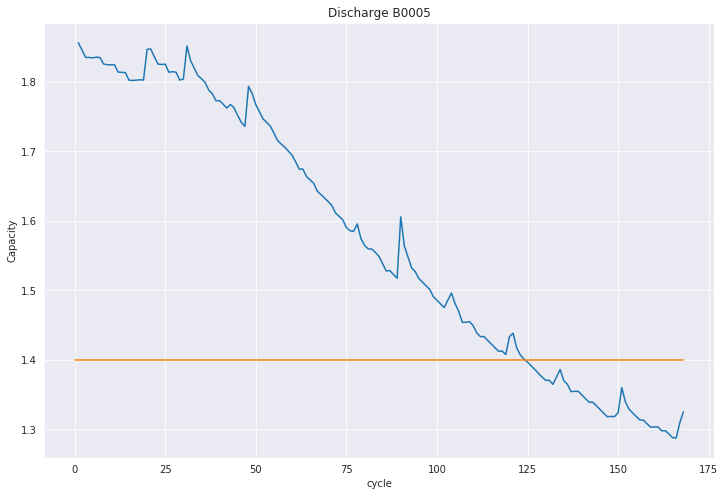

In [4]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

Es necesario igualmente calcular el SoH de la bateria, ya que este es el dato que se va a predecir haciendo uso del modelo de *deep learning*

In [5]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Igualmente a lo hecho anteriormente, se realiza una gráfica del SoH por cada ciclo, la línea horizontal representa el threshold del 70% en el cual la bateria ya cumple su ciclo de vida y ya es recomendable hacer el cambio.

Text(0.5, 1.0, 'Discharge B0005')

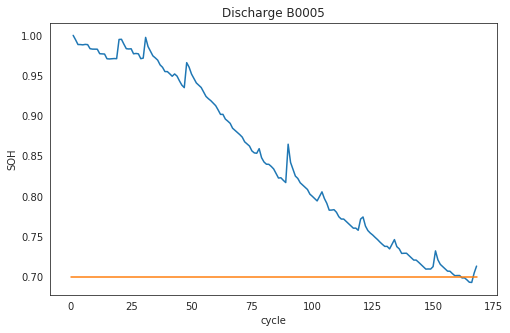

In [6]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

## Fase de entrenamiento para el calculo del SoH
Se prepara el dataset de tal manera que pueda ser usado por Tensorflow en la fase de entrenamiento, para esto se crean dos estructuras correspondientes a la entrada y salida que se espera obtener. Para los datos de entrada se filtran y las caracteristicas relevantes del dataset los cuales son:
* Capacidad de la batería
* Voltaje
* Corriente
* Temperatura
* Voltaje de carga
* Corriente de carga
* Instante de tiempo (desde el inicio de la descarga)

Para los datos de la salida se calcula el SoH de la bateria y en ambos casos de entrada y salida, los valores se normalizan a un rango de valores entre [0-1].

In [7]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


Preparacion del modelo, se usa 3 capas densas, y se usan los parametros tal cual se encuentran en el paper: 3 capas densas y una de dropout, y como optimizador se usa uno de tipo ADAM

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [9]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 64        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


Se procede a entrenar el modelo, se usan 20 epochs para el entrenamiento

In [10]:
model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=50)

Train on 50285 samples
Epoch 1/50
50285/50285 [==============================] - 8s 156us/sample - loss: 0.1207
Epoch 2/50
50285/50285 [==============================] - 7s 131us/sample - loss: 0.0296
Epoch 3/50
50285/50285 [==============================] - 7s 130us/sample - loss: 0.0228
Epoch 4/50
50285/50285 [==============================] - 7s 131us/sample - loss: 0.0226
Epoch 5/50
50285/50285 [==============================] - 7s 133us/sample - loss: 0.0223
Epoch 6/50
50285/50285 [==============================] - 6s 128us/sample - loss: 0.0220
Epoch 7/50
50285/50285 [==============================] - 7s 130us/sample - loss: 0.0222
Epoch 8/50
50285/50285 [==============================] - 7s 130us/sample - loss: 0.0221
Epoch 9/50
50285/50285 [==============================] - 7s 129us/sample - loss: 0.0221
Epoch 10/50
50285/50285 [==============================] - 7s 131us/sample - loss: 0.0220
Epoch 11/50
50285/50285 [==============================] - 7s 131us/sample - loss: 0.0

## Testing para probar el modelo de predicción del SoH
Para probar la correctitud del modelo se carga la información de la misma bateria (B0006)

In [59]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

Se crea una tabla que contiene el SoH real y el SoH que la red predijo y se calcula la raiz del error cuadratico medio

In [60]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
print('Root Mean Square Error: ', rms)

(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  0.959172
1      2  0.994990  0.956460
2      3  0.989185  0.953311
3      4  0.989165  0.953293
4      5  0.982898  0.949908
5      6  0.989467  0.953456
6      7  0.989075  0.953246
7      8  0.967304  0.941484
8      9  0.966997  0.941313
9     10  0.961625  0.938410
Root Mean Square Error:  0.09088712307694548


Finalmente se gráfican ambos SoH para observar sus diferencias

Text(0.5, 1.0, 'Discharge B0006')

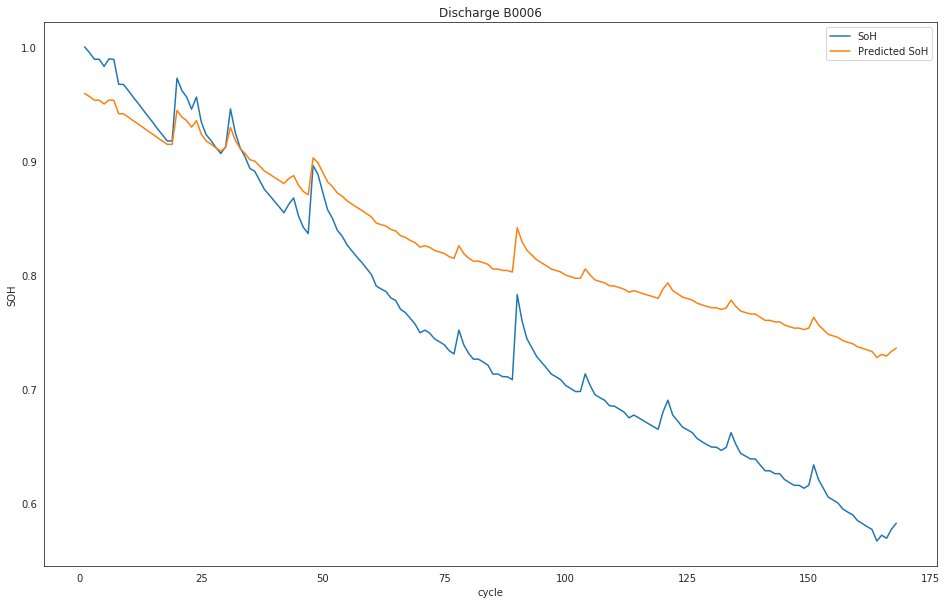

In [61]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

Para la estimación del SoH, se puede observar que el patrón de datos es aprendido por el modelo correctamente, tal como predice la teoría, ya que la forma de las curvas es casi idéntica. El SoH que se muestra tiene el mismo comportamiento al esperado en la teoría, lo que se corrobora con el valor de raíz de error cuadrático medio del gráfico de la ilustración 8, cuyo valor de 9% es muy similar al encontrado anteriormente. Con esto se reafirma la precisión al momento de hacer la predicción.

## Estimación del RUL
De similar forma que se hizo para la estimación del SoH, se prepara el dataset de entrenamiento y de testing, en este caso en particular se usan los datos de la capacidad de la batería usando los primeros datos de los primeros 50 ciclos para así predecir la capacidad en los siguientes ciclos de tal manera de poder saber cuando se alcanza el threshold de la bateria y estimar los ciclos faltantes para llegar al End of Life de la batería

In [48]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


En esta sección se entrena el modelo, basandonos en la propuesta de [2] y haciendo uso de redes tipo LSTM en vez de redes neuronales estandar.

In [49]:
regress = Sequential()
regress.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200))
regress.add(Dropout(0.3))
regress.add(Dense(units=1))
regress.compile(optimizer='adam',loss='mean_squared_error')
regress.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 10, 200)           161600    
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 10, 200)           320800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 200)           320800    
_________________________________________________________________
dropout_23 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 200)              

In [50]:
regress.fit(X_train,y_train,epochs=200,batch_size=25)

Train on 39 samples
Epoch 1/200
39/39 [==============================] - 4s 106ms/sample - loss: 0.3261
Epoch 2/200
39/39 [==============================] - 0s 683us/sample - loss: 0.1315
Epoch 3/200
39/39 [==============================] - 0s 676us/sample - loss: 0.1014
Epoch 4/200
39/39 [==============================] - 0s 633us/sample - loss: 0.0421
Epoch 5/200
39/39 [==============================] - 0s 647us/sample - loss: 0.0662
Epoch 6/200
39/39 [==============================] - 0s 643us/sample - loss: 0.0616
Epoch 7/200
39/39 [==============================] - 0s 737us/sample - loss: 0.0466
Epoch 8/200
39/39 [==============================] - 0s 765us/sample - loss: 0.0528
Epoch 9/200
39/39 [==============================] - 0s 794us/sample - loss: 0.0470
Epoch 10/200
39/39 [==============================] - 0s 763us/sample - loss: 0.0417
Epoch 11/200
39/39 [==============================] - 0s 680us/sample - loss: 0.0460
Epoch 12/200
39/39 [==============================] - 

In [55]:
print(len(data_test))
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)

119


In [56]:
X_test=[]
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred=regress.predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)
metrics.r2_score(tests,pred)

(119, 1)
Test RMSE: 0.050


0.8655908035539039

Como se puede observar, el RMSE medio es de 0.05 (5%) el cual se acerca mucho a los valores que la literatura observa haciendo uso de este tipo de redes.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

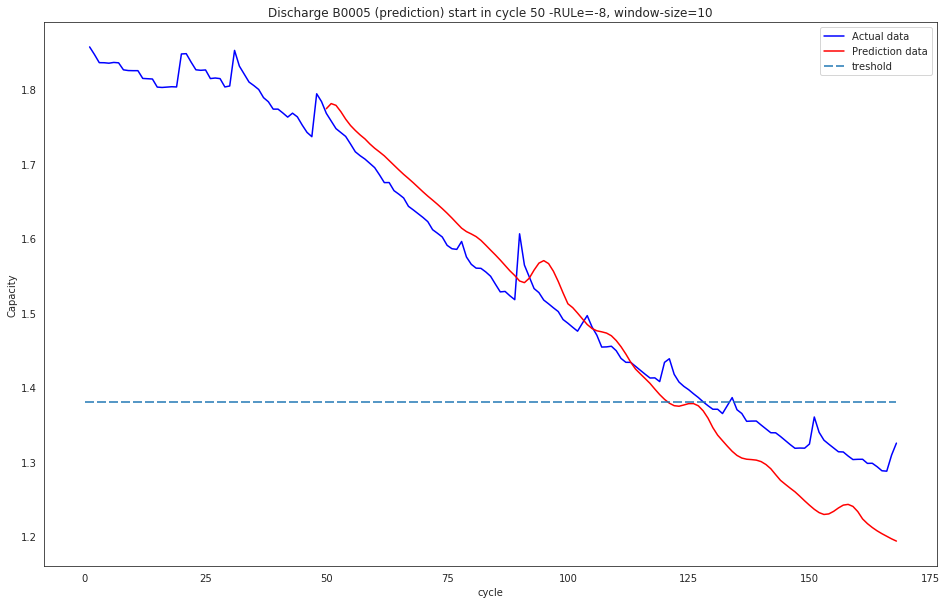

In [57]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

Finalmente, se puede apreciar en la gráfica que el valor de la capacidad y como se comporta a travéz del tiempo es muy cercano al valor real y apoyando estos datos, el error en la estimación del RUL fue de -8 el cual nos hace entender que el modelo se adelantó en 8 ciclos a estimar que la bateria llegó a su fin de ciclo de vida.

In [58]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 120
The error of RUL= -8 Cycle(s)


## Bibliografía
[1] P. Khumprom and N. Yodo, “A data-driven predictive prognostic model for lithium-ion batteries based on a deep learning algorithm,” Energies, vol. 12, no. 4, 2019.

[2] C. Wang, N. Lu, S. Wang, Y. Cheng, and B. Jiang, “Dynamic long short-term memory neural-network- based indirect remaining-useful-life prognosis for satellite Lithium-ion battery,” Appl. Sci., vol. 8, no. 11, 2018.

[3] Parte del código utilizado está basado en: https://github.com/Kalrfou/CapstoneProject